In [1]:
import numpy as np
import pandas as pd
import sqlite3

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, dollar_format

# GET COMPANIES AND PRICE HISTORY

In [2]:
con = sqlite3.connect('market.db')

sp5_list = pd.read_sql('''
    SELECT *
    FROM sp5_list 
    ''', con)

sp5_price_history = (pd.read_sql('''
    SELECT Date, Symbol, Adj_Close AS Close
    FROM histories
    WHERE Symbol IN (
        SELECT Symbol
        FROM sp5_list) 
    ''', con, parse_dates=['Date'])
    .pivot(index='Date', columns='Symbol', values='Close'))

# display(sp5_list)
# display(sp5_price_history)

# GET RETURN, QUANTILE, AND RANK HISTORIES

In [3]:
def get_return_history(df, days):
    return (df/df.shift(days) - 1).dropna(axis=0, how='all')*100


def get_quantile_history(df, window, quantile):
    return df.rolling(window).quantile(quantile).dropna(axis=0, how='all')


def get_rank_history(df):
    return df.rank(axis=1, method='first', ascending=False).astype('int64')


def get_tail_days(df, days):
    return df.tail(days).dropna(axis=1, how='any')


return_window = 63
quantile_window = 252
quantile = 0.75
rank_window = 2*252

sp5_return_history = get_return_history(
    sp5_price_history,
    return_window)

sp5_quantile_history = get_quantile_history(
    sp5_return_history,
    quantile_window,
    quantile)

sp5_rank_history = get_rank_history(
    get_tail_days(
        sp5_quantile_history,
        rank_window))

# display(sp5_return_history)
# display(sp5_quantile_history)
# display(sp5_rank_history)

# GET TOP SYMBOLS

In [4]:
sp5_top_symbols = sp5_rank_history.iloc[-1].nsmallest(25).index.to_list()

sp5_top_list = (sp5_list
    .set_index('Symbol')
    .loc[sp5_top_symbols]
    .reset_index())

display(sp5_top_list)

,Symbol,Name,Sector,Industry
0,MRNA,Moderna,Health Care,Biotechnology
1,APA,APA Corporation,Energy,Oil & Gas Exploration & Production
2,NVDA,Nvidia,Information Technology,Semiconductors
3,MRO,Marathon Oil,Energy,Oil & Gas Exploration & Production
4,DVN,Devon,Energy,Oil & Gas Exploration & Production
5,CTRA,Coterra,Energy,Oil & Gas Exploration & Production
6,MOS,Mosaic,Materials,Fertilizers & Agricultural Chemicals
7,CF,CF Industries,Materials,Fertilizers & Agricultural Chemicals
8,AMD,AMD,Information Technology,Semiconductors
9,IT,Gartner,Information Technology,IT Consulting & Other Services


# PLOT TOP SYMBOLS

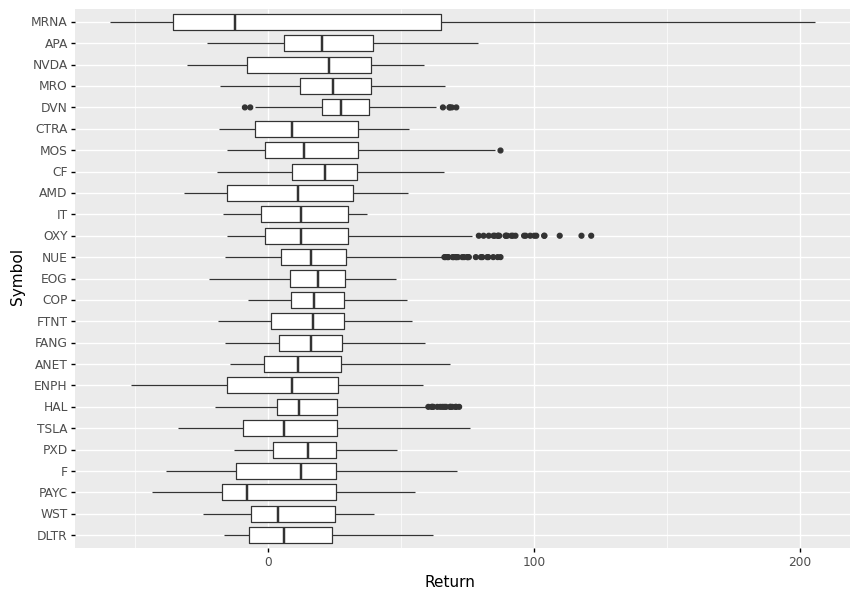

<ggplot: (8768012463876)>

In [5]:
df = (sp5_return_history[sp5_top_symbols]
    .pipe(get_tail_days, quantile_window)
    .melt(value_name='Return', ignore_index=False)
    .reset_index()
    )

p = (p9.ggplot(df)
    + p9.theme(figure_size=(10, 7))
    + p9.geom_boxplot(mapping=p9.aes(x='Symbol', y='Return'))
    + p9.coord_flip()
    + p9.scale_x_discrete(limits=sp5_top_symbols[::-1])
    )

display(p)

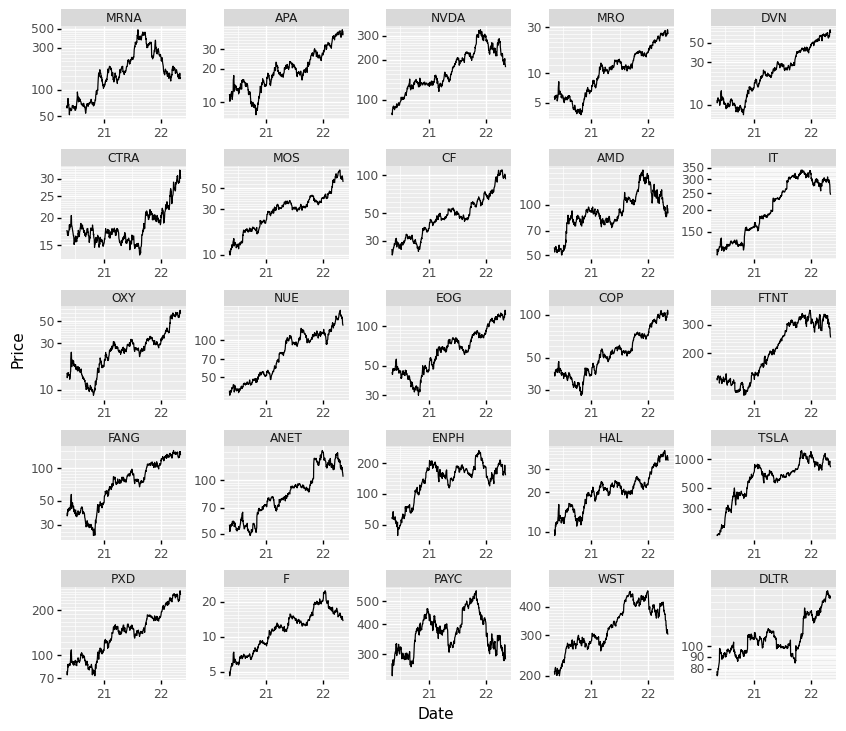

<ggplot: (8767892076011)>

In [6]:
df = (sp5_price_history[sp5_top_symbols]
    .pipe(get_tail_days, rank_window)
    .melt(value_name='Price', ignore_index=False)
    .reset_index()
    )

df['Symbol'] = (df['Symbol']
    .astype('category')
    .cat.reorder_categories(sp5_top_symbols)) 

width = 10
ncol = 5
nrow = np.ceil(len(df['Symbol'].unique())/ncol)

p = (p9.ggplot(df)
    + p9.theme(figure_size=(width, 0.85*width/ncol*nrow))
    + p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y'))
    + p9.geom_line(mapping=p9.aes(x='Date', y='Price'))
    + p9.scale_y_log10()
    + p9.facet_wrap('Symbol', ncol=ncol, scales='free')
    + p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})
    )

display(p)